In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from exp.nb_05b import *
torch.set_num_threads(2)

## ConvNet

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

In [4]:
def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [6]:
x_train.mean(), x_train.std()

(tensor(0.0001), tensor(1.))

In [7]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

In [9]:
def flatten(x): return x.view(x.shape[0], -1)
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d(1, 8, 5, padding=2, stride=2), nn.ReLU(), # 14
        nn.Conv2d(8, 16, 3, padding=1, stride=2), nn.ReLU(), # 7
        nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.ReLU(), # 4
        nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )

In [11]:
model = get_cnn_model(data)

In [12]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [13]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [14]:
%time run.fit(1, learn)

train: [1.54947484375, tensor(0.4887)]
valid: [0.339516943359375, tensor(0.9071)]
CPU times: user 33.8 s, sys: 33.2 s, total: 1min 6s
Wall time: 10.2 s


## Cuda

In [15]:
device = torch.device('cuda', 0)

In [16]:
class CudaCallback(Callback):
    def __init__(self, device): self.device = device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self):
        self.run.xb, self.run.yb = self.xb.to(self.device), self.yb.to(self.device)

In [17]:
torch.cuda.set_device(device)

In [18]:
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb, self.run.yb = self.xb.cuda(), self.yb.cuda()

In [19]:
cbfs.append(CudaCallback)

In [20]:
model = get_cnn_model(data)

In [21]:
opt = optim.SGD(model.parameters(), lr=.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [22]:
%time run.fit(3, learn)

train: [2.1414171875, tensor(0.2576, device='cuda:0')]
valid: [1.2609201171875, tensor(0.5442, device='cuda:0')]
train: [0.660866953125, tensor(0.7907, device='cuda:0')]
valid: [0.258877392578125, tensor(0.9284, device='cuda:0')]
train: [0.21370439453125, tensor(0.9343, device='cuda:0')]
valid: [0.15232880859375, tensor(0.9539, device='cuda:0')]
CPU times: user 4.72 s, sys: 1.52 s, total: 6.24 s
Wall time: 27.5 s


## Refactor model

In [23]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [24]:
class BatchTransformXCallback(Callback):
    _order = 2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)
        
def view_tfm(*size):
    def _inner(x): return x.view(*((-1,) + size))
    return _inner

In [25]:
mnist_view = view_tfm(1, 28, 28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [26]:
nfs = [8, 16, 32, 32]

In [27]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [28]:
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [29]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=.4, cbs=cbfs)

In [30]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [31]:
run.fit(3, learn)

train: [1.6233525, tensor(0.4386, device='cuda:0')]
valid: [0.424233251953125, tensor(0.8711, device='cuda:0')]
train: [0.3361498828125, tensor(0.8984, device='cuda:0')]
valid: [0.19823858642578124, tensor(0.9432, device='cuda:0')]
train: [0.17726740234375, tensor(0.9456, device='cuda:0')]
valid: [0.14860843505859375, tensor(0.9537, device='cuda:0')]


## Hooks

### Manual insertion

In [32]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            if self.training:
                self.act_means[i].append(x.mean())
                self.act_stds[i].append(x.std())
        return x
    
    def __iter__(self): return iter(self.layers)

In [33]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=.9, cbs=cbfs)

In [34]:
run.fit(2, learn)

train: [2.33775765625, tensor(0.1369, device='cuda:0')]
valid: [2.3025544921875, tensor(0.1064, device='cuda:0')]
train: [1.843760625, tensor(0.3306, device='cuda:0')]
valid: [0.70323916015625, tensor(0.7498, device='cuda:0')]


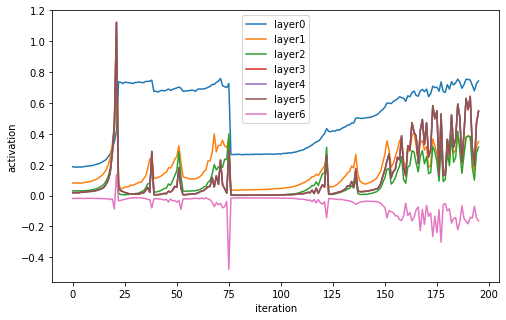

In [35]:
fig, ax = plt.subplots(figsize=(8, 5))
for l, m in enumerate(model.act_means): 
    ax.plot(m, label=f"layer{l}")
    ax.legend()
    ax.set_xlabel('iteration')
    ax.set_ylabel('activation');

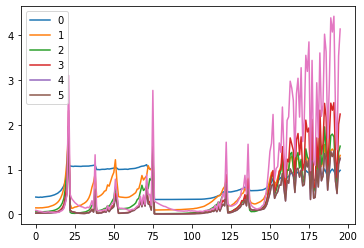

In [36]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6))

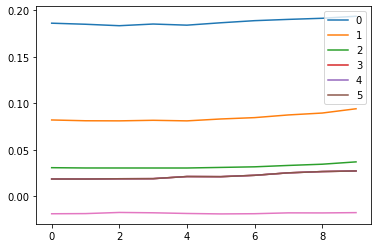

In [37]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6))

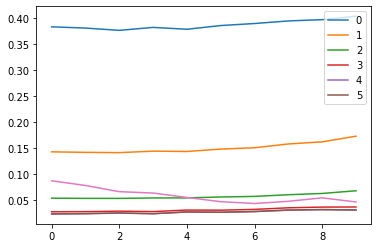

In [38]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6))

### Pytorch hooks

In [39]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=.5, cbs=cbfs)

In [40]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [41]:
def append_stats(i, m, inp, outp):
    if m.training:
        act_means[i].append(outp.data.mean())
        act_stds[i].append(outp.data.std())

In [42]:
for i, l in enumerate(model):
    l.register_forward_hook(partial(append_stats, i))

In [43]:
run.fit(1, learn)

train: [2.04414203125, tensor(0.2796, device='cuda:0')]
valid: [1.3256228515625, tensor(0.5402, device='cuda:0')]


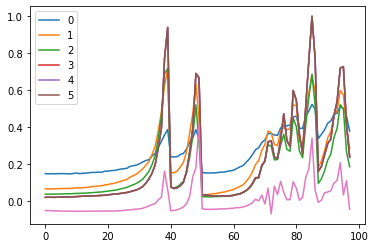

In [44]:
for o in act_means: plt.plot(o)
plt.legend(range(6))

### Hook class

In [45]:
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f):
        self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()
        
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    means, stds = hook.stats
    if mod.training:
        means.append(outp.data.mean())
        stds.append(outp.data.std())

In [46]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [47]:
hooks = [Hook(m, append_stats) for m in model[:4]]

In [48]:
run.fit(1, learn)

train: [2.15663625, tensor(0.2545, device='cuda:0')]
valid: [1.44953994140625, tensor(0.5324, device='cuda:0')]


Text(0.5, 1.0, 'Activation Mean')

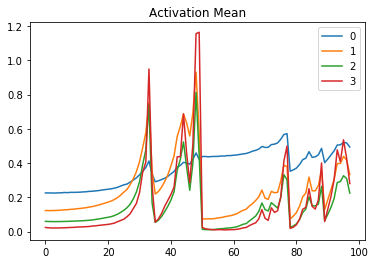

In [49]:
for h in hooks: plt.plot(h.stats[0])
plt.legend(range(4))
plt.title('Activation Mean')

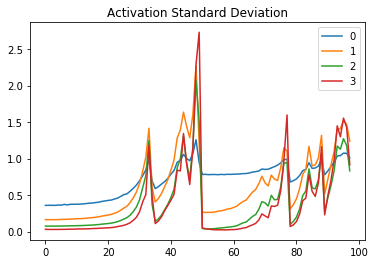

In [50]:
for h in hooks: plt.plot(h.stats[1])
plt.legend(range(4))
plt.title('Activation Standard Deviation');

### A Hooks class

In [51]:
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        try: return self.items[idx]
        except TypeError:
            if isinstance(idx[0], bool):
                assert len(idx) == len(self)
                return [v for m, v in zip(idx, self.items) if m]
            return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, v): self.items[i] = v
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self): 
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [52]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [53]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [54]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

In [55]:
t[tensor(3)]

3

In [107]:
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [153]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [154]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7fb42c72b4a8>, <__main__.Hook object at 0x7fb42c72b9e8>, <__main__.Hook object at 0x7fb42c72b0b8>, <__main__.Hook object at 0x7fb42c72bdd8>, <__main__.Hook object at 0x7fb42c7029e8>, <__main__.Hook object at 0x7fb42c105b38>, <__main__.Hook object at 0x7fb42c105550>]

In [155]:
hooks.remove()

In [156]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [157]:
x.mean(), x.std()

(tensor(0.0061, device='cuda:0'), tensor(1.0069, device='cuda:0'))

In [158]:
p = model[0](x)

In [159]:
p.mean(), p.std()

(tensor(0.2506, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(0.2687, device='cuda:0', grad_fn=<StdBackward0>))

In [160]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [161]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.5440, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(1.0910, device='cuda:0', grad_fn=<StdBackward0>))

train: [2.027376875, tensor(0.3572, device='cuda:0')]
valid: [0.97240947265625, tensor(0.6784, device='cuda:0')]
train: [0.403106015625, tensor(0.8708, device='cuda:0')]
valid: [0.14327987060546876, tensor(0.9572, device='cuda:0')]


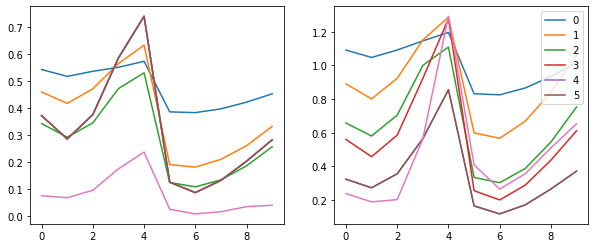

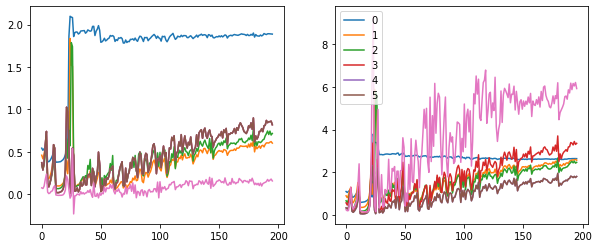

In [162]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        axs[0].plot(ms[:10])
        axs[1].plot(ss[:10])
    plt.legend(range(6))
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        axs[0].plot(ms)
        axs[1].plot(ss)
    plt.legend(range(6))
    
    

# fin